# Imports necesarios

In [104]:
import sys
import os
import random
import string
import subprocess
import matplotlib.pyplot as plt
import numpy as np

In [105]:
def armarArchivo(cantLineas, index, experimento):

    # Número de strings a generar
    num_strings = cantLineas

    # Longitud máxima del string
    longitud_maxima = 3

    # Nombre del archivo de salida
    archivo_salida = f'../Experimentos/data/Experimento{experimento}/generado{index}.txt'

    # Generar y guardar los strings en el archivo
    with open(archivo_salida, 'w') as f:
        for _ in range(num_strings):
            longitud = random.randint(1, longitud_maxima)
            string_generado = random.choice(string.ascii_lowercase) + ''.join(random.choices(string.ascii_lowercase + string.digits, k=longitud-1))
            f.write(string_generado + '\n')
    return archivo_salida

In [106]:
def ordenarArchivo(archivo):
    # Nombre del archivo de entrada y salida
    archivo_salida = archivo.replace(".txt", "")
    archivo_salida = f'{archivo_salida}Ordenado.txt'
    # Leer las líneas del archivo de entrada
    with open(archivo, 'r') as f:
        lineas = f.readlines()

    # Ordenar alfabéticamente las líneas
    lineas_ordenadas = sorted(lineas)

    # Escribir las líneas ordenadas en el archivo de salida
    with open(archivo_salida, 'w') as f:
        f.writelines(lineas_ordenadas)


# Preparacion para Experimento 1:

1.1) Preparamos 10 archivos con 5.000 palabras cada uno. Luego los ordenamos alfabeticamente. En este experimento la hipótesis es que como los threads encontraran muy seguido puntos de acumulación de palabras similares entonces no podrán aprovechar la concurrencia -la mayoría de ellos caeran en esquemas secuenciales- y por ende no veremos mejora al incrementar la cantidad de threads. Más aún, posiblemente veamos que aumentar la cantidad de threads sea contraproducente, puesto que muchos de ellos comenzarán a bloquearse. 

Se determina por cuestiones asociadas a la implementación del código que no tiene sentido disparar mas threads que archivos, dado que cualquier aquellos threads extra que se creen no tendrán indice que mirar dentro del arreglo de archivos, no harán nada y terminarán.

In [107]:
def PrepararExperimento1(ordenar):
    archivos = []
    for i in range (10):
        archivos.append(armarArchivo(5000, i, 1))
    if(not ordenar): return
    for i in archivos:
        ordenarArchivo(i)

maxCantThreads = 10
corridasPorThread = 100
cantArchivosPorThread = 10

In [108]:
PrepararExperimento1(True)

In [109]:
def CorrerExperimento11():
    matrizTiempos = []

    archivos = []
    for i in range(cantArchivosPorThread):
        archivos.append(f'../Experimentos/data/Experimento1/generado{1}Ordenado.txt')

    for i in range(maxCantThreads):
        filaResultados = []
        for j in range(corridasPorThread):
            proc = subprocess.Popen(['../build/ContarPalabrasExperimentar', str(i), str(0)]+archivos, 
                                    stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            exitCode = proc.wait()
            if exitCode != 0: print(proc.stderr.read())
            result = str(proc.stdout.read())
            result = result.replace("b'", "")
            result = result.split(' ')
            filaResultados.append(float(result[0]))
        matrizTiempos.append(filaResultados)
        
    return matrizTiempos

In [110]:
datosExperimento11 = CorrerExperimento11()
datosExperimento11

[[0.376615, 0.350218, 0.36077, 0.381326, 0.355277],
 [0.344315, 0.357409, 0.349882, 0.344048, 0.3485],
 [0.211541, 0.211497, 0.218491, 0.229657, 0.228993],
 [0.477114, 0.419856, 0.397171, 0.41106, 0.244129],
 [0.443814, 0.504408, 0.365801, 0.294602, 0.561108],
 [0.424344, 0.414417, 0.424554, 0.504544, 0.494737],
 [0.406262, 0.4747, 0.548615, 0.20538, 0.498031],
 [0.445905, 0.1917, 0.401653, 0.208911, 0.31325],
 [0.329042, 0.194276, 0.356766, 0.464533, 0.451184],
 [0.406336, 0.498889, 0.498635, 0.530961, 0.460813]]

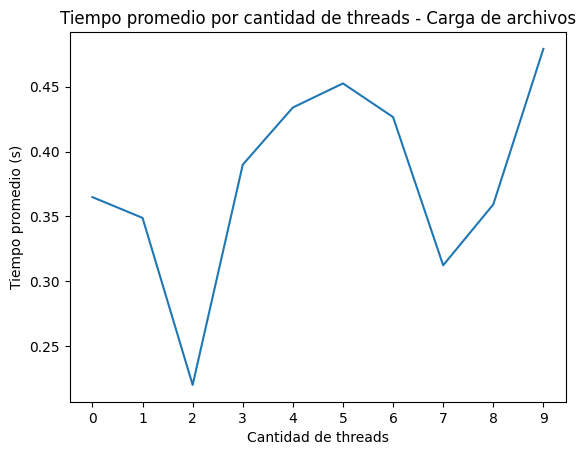

In [111]:
promedios = [sum(fila) / len(fila) for fila in datosExperimento11]

# Plotear el gráfico
plt.plot(range(maxCantThreads), promedios)
plt.xticks(range(maxCantThreads))
plt.xlabel('Cantidad de threads')
plt.ylabel('Tiempo promedio (s)')
plt.title('Tiempo promedio por cantidad de threads - Carga de archivos')
plt.show()

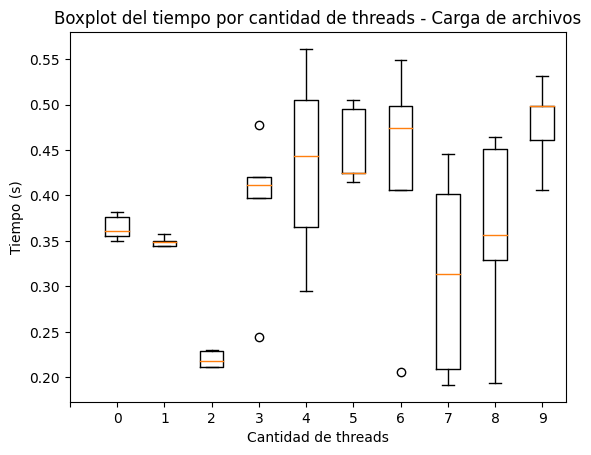

In [112]:
promedios = [np.mean(fila) for fila in datosExperimento11]
varianzas = [np.var(fila) for fila in datosExperimento11]

# Crear un array con los datos en el formato adecuado para el boxplot
datos_boxplot = [fila for fila in datosExperimento11 if fila]

# Plotear el boxplot
plt.boxplot(datos_boxplot)
plt.xlabel('Cantidad de threads')
plt.ylabel('Tiempo (s)')
plt.title('Boxplot del tiempo por cantidad de threads - Carga de archivos')
plt.xticks(range(maxCantThreads+1),['', '0', '1', '2', '3','4','5','6','7','8','9'])
plt.show()

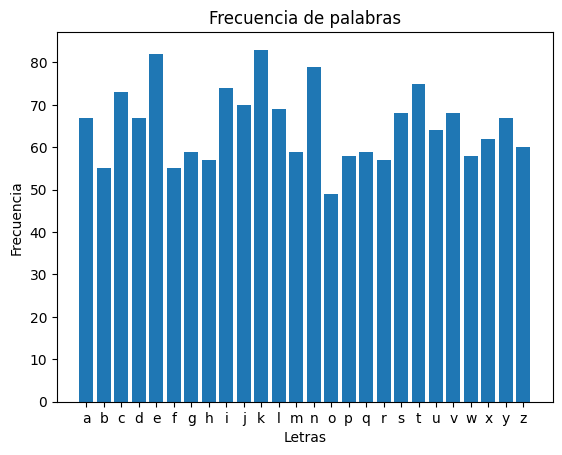

In [113]:
import matplotlib.pyplot as plt
import collections

def plot_word_frequency(filename):
    with open(filename, 'r') as file:
        words = [word.strip() for word in file.readlines()]

    counter = collections.Counter(words)
    word_freq = counter.most_common()

    word_freq.sort(key=lambda x: x[0][0])

    x_values = [word[0][0] for word in word_freq]
    y_values = [word[1] for word in word_freq]

    # Crear el gráfico de barras
    plt.bar(x_values, y_values)

    plt.xlabel('Letras')
    plt.ylabel('Frecuencia')
    plt.title('Frecuencia de palabras')


    plt.show()

plot_word_frequency('../Experimentos/data/Experimento1/generado0Ordenado.txt')

Del anterior gráfico se deduce el comportamiento de corrimiento de acumulación. Este punto está explicado en el informe adjunto a la experimentación.

# Preparación experimento 1.2

En este caso utilizaremos archivos que no están ordenados alfabéticamente. La hipótesis es que cuando los threads empiecen a cargar los archivos, como estos no tienen puntos de acumulación de entradas similares -que empiezan por la misma letra- entonces los threads se ven menos comunmente forzados a caer en esquemas secuenciales -porque entran en juego las estrategias de contención de concurrencia- y por ende se puede aprovechar de mejor manera el paralelismo, teniendo mejores resultados.

In [114]:
def CorrerExperimento12():
    matrizTiempos = []

    archivos = []
    for i in range(cantArchivosPorThread):
        archivos.append(f'../Experimentos/data/Experimento1/generado{i}.txt')

    for i in range(maxCantThreads):
        filaResultados = []
        for j in range(corridasPorThread):
            proc = subprocess.Popen(['../build/ContarPalabrasExperimentar', str(i), str(0)]+archivos, 
                                    stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            exitCode = proc.wait()
            if exitCode != 0: print(proc.stderr.read())
            result = str(proc.stdout.read())
            result = result.replace("b'", "")
            result = result.split(' ')
            filaResultados.append(float(result[0]))
        matrizTiempos.append(filaResultados)
        
    return matrizTiempos

In [115]:
datosExperimento12 = CorrerExperimento12()
datosExperimento12

[[7.52926, 6.59157, 6.60041, 7.02168, 8.9268],
 [6.55529, 7.00607, 6.63595, 7.22496, 7.10949],
 [5.14468, 4.09519, 4.31661, 4.61905, 4.71043],
 [4.3902, 4.23745, 3.81588, 3.92903, 4.62534],
 [3.51817, 3.65395, 3.53885, 3.80346, 3.50256],
 [2.93275, 2.82081, 2.79347, 3.02358, 2.9482],
 [2.83601, 2.80915, 2.79318, 2.88325, 2.68185],
 [2.95431, 2.90111, 2.88669, 2.8984, 2.90992],
 [3.0757, 3.4844, 3.41834, 3.85179, 3.18661],
 [3.34055, 3.44185, 3.68738, 3.71504, 3.56749]]

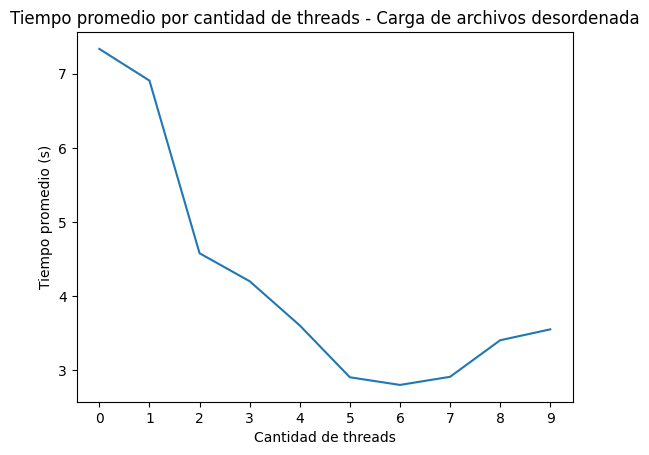

In [116]:
promedios12 = [sum(fila) / len(fila) for fila in datosExperimento12]

# Plotear el gráfico
plt.plot(range(maxCantThreads), promedios12)
plt.xticks(range(maxCantThreads))
plt.xlabel('Cantidad de threads')
plt.ylabel('Tiempo promedio (s)')
plt.title('Tiempo promedio por cantidad de threads - Carga de archivos desordenada')
plt.show()

#Experimento 2: Buscar maximo

Habiendo encontrado la configuración de threads para 10 archivos que maximiza el performance de la carga, ahora nos gustaría determinar que sucede al momento de buscar el máximo. La hipótesis es que aumentar los threads que disponemos para calcular el maximo elevará el rendimiento del algoritmo. 

Es importante notar que no tiene sentido utilizar mas de 26 threads. Dado que nuestro hash-map tiene 26 entradas, y dado que cada thread hará una búsqueda lineal sobre las listas asociadas a esas entradas, introducir mas de 26 threads no otorgará beneficio, ya que para cada entrada disponible en la tabla ya habrá un thread corriendo sobre ella.

A fines de este experimento no tiene sentido utilizar los archivos ordenados, ya que solo modificará el tiempo de carga y no modificará la velocidad de encontrar el máximo. Por este motivo, se utilizan 10 threads sobre los 10 archivos desordenados.

In [122]:
def PrepararExperimento2():
    archivos = []
    for i in range (10):
        archivos.append(armarArchivo(5000, i, 2))

maxCantThreads = 26
corridasPorThread = 100
cantArchivosPorThread = 10

In [118]:
def CorrerExperimento21():
    matrizTiempos = []

    archivos = []
    for i in range(cantArchivosPorThread):
        archivos.append(f'../Experimentos/data/Experimento1/generado{i}.txt')

    for i in range(maxCantThreads):
        filaResultados = []
        for j in range(corridasPorThread):
            proc = subprocess.Popen(['../build/ContarPalabrasExperimentar', str(cantArchivosPorThread), str(i)]+archivos, 
                                    stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            exitCode = proc.wait()
            if exitCode != 0: print(proc.stderr.read())
            result = str(proc.stdout.read())
            result = result.replace("b'", "")
            result = result.split(' ')
            filaResultados.append(float(result[1]))
        matrizTiempos.append(filaResultados)
        
    return matrizTiempos

In [119]:
PrepararExperimento2()
datosExperimento21 = CorrerExperimento21()
datosExperimento21

[[0.000436705, 0.0002519, 0.000395959, 0.000450504, 0.000211026],
 [0.00104332, 0.000871018, 0.00113275, 0.000617122, 0.000667748],
 [0.000596151, 0.00043283, 0.000505454, 0.000705644, 0.000568292],
 [0.0003101, 0.000417373, 0.000407113, 0.000345668, 0.000348715],
 [0.000260092, 0.00058611, 0.000294897, 0.000303972, 0.000506735],
 [0.000299395, 0.000595017, 0.000391566, 0.000293215, 0.000456296],
 [0.000410653, 0.000522875, 0.000290314, 0.000601517, 0.000605866],
 [0.000314378, 0.000383552, 0.0003481, 0.000370605, 0.000351139],
 [0.00042307, 0.000371556, 0.000361508, 0.000533807, 0.000375895],
 [0.000376906, 0.000371389, 0.000427393, 0.000577349, 0.000404473],
 [0.000442756, 0.000432354, 0.000417634, 0.00036651, 0.000419695],
 [0.000589532, 0.000568026, 0.000444991, 0.00041975, 0.000426785],
 [0.000518854, 0.000666078, 0.000483669, 0.000457282, 0.000598489],
 [0.000646036, 0.00053662, 0.000495463, 0.000621136, 0.000516084],
 [0.000545237, 0.00054178, 0.000539753, 0.000554519, 0.0006406

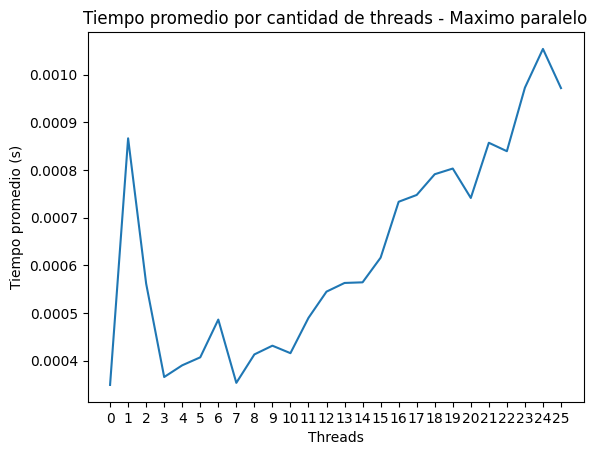

In [127]:
promedios21 = [sum(fila) / len(fila) for fila in datosExperimento21]

# Plotear el gráfico
plt.plot(range(maxCantThreads), promedios21)
plt.xticks(range(maxCantThreads))
plt.xlabel('Threads')
plt.ylabel('Tiempo promedio (s)')
plt.title('Tiempo promedio por cantidad de threads - Maximo paralelo')
plt.show()

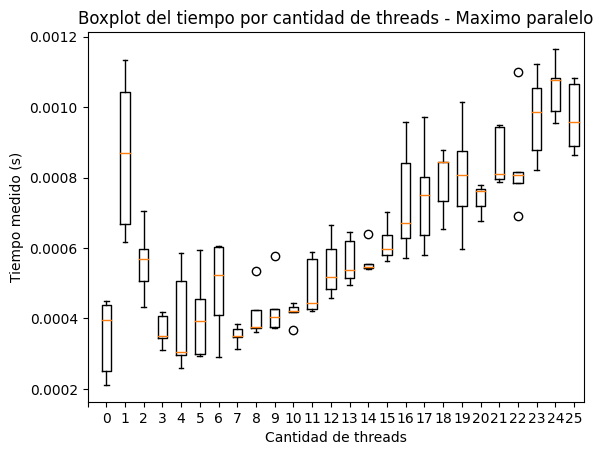

In [128]:
promedios = [np.mean(fila) for fila in datosExperimento21]
varianzas = [np.var(fila) for fila in datosExperimento21]

# Crear un array con los datos en el formato adecuado para el boxplot
datos_boxplot = [fila for fila in datosExperimento21 if fila]

# Plotear el boxplot
plt.boxplot(datos_boxplot)
plt.xlabel('Cantidad de threads')
plt.ylabel('Tiempo medido (s)')
plt.title('Boxplot del tiempo por cantidad de threads - Maximo paralelo')
plt.xticks(range(maxCantThreads+1),['', '0', '1', '2', '3','4','5','6','7','8','9', '10', '11', '12', 
                                    '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
                                    '24', '25'])
plt.show()